# Notebook to plot classification results

In [1]:
# ==========================================
# CLEANED CLASSIFICATION PLOTTING PIPELINE
# ==========================================

from __future__ import annotations
import numpy as np
import pandas as pd
import json, os, re
from pathlib import Path
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# =======================
# COLOR + STYLE CONFIG
# =======================

COLOR_IMAGE_CLIP = "cornflowerblue"      # Image+CLIP
COLOR_IMAGE_ONLY = "mediumseagreen"
COLOR_RANDOM = "lightcoral"

CMAP_IMAGE_CLIP = LinearSegmentedColormap.from_list('clip_cmap', ['white', COLOR_IMAGE_CLIP])
CMAP_RANDOM = LinearSegmentedColormap.from_list('rand_cmap', ['white', COLOR_RANDOM])

SERIES_STYLES = {
    "Image+CLIP":  {"color": COLOR_IMAGE_CLIP, "marker": "o"},
    "Image-only":  {"color": COLOR_IMAGE_ONLY, "marker": "s"},
    "Random init": {"color": COLOR_RANDOM,     "marker": "X"},
}


# =======================
# FILENAME PARSING
# =======================

def parse_tag(tag):
    pat = re.compile(
        r"^(?P<init_mode>pretrained|random)_"
        r"(?P<split>cvfold\d+|percent_[^_]*)_"
        r"ntr(?P<ntr>\d+)_ntest(?P<ntest>\d+)"
        r"_fttr(?P<fttr>\d+)_ftval(?P<ftval>\d+)_seed(?P<seed>\d+)$"
    )
    m = pat.match(tag)
    if not m:
        return None
    d = m.groupdict()
    for k in ["ntr", "ntest", "fttr", "ftval", "seed"]:
        d[k] = int(d[k])
    return d


def safe_float(cell, key):
    cell = str(cell)
    if cell.startswith(key + "="):
        return float(cell.split("=", 1)[1])
    return float('nan')


def read_overall_metrics(csv_path):
    df = pd.read_csv(csv_path)
    last = df.iloc[-1]

    acc = safe_float(last.get("precision"), "ACC")
    macro_f1 = safe_float(last.get("recall"), "MACRO_F1")
    support = int(last.get("support", 0)) if pd.notna(last.get("support")) else 0

    return acc, macro_f1, support


# =======================
# SCANNING METRICS
# =======================

def collect_runs(metrics_root):
    rows = []
    metrics_root = Path(metrics_root)

    if not metrics_root.exists():
        print(f"[WARN] metrics root missing: {metrics_root}")
        return pd.DataFrame()

    for sub in sorted(metrics_root.iterdir()):
        if not sub.is_dir(): 
            continue

        tag = sub.name
        meta = parse_tag(tag)
        if meta is None:
            continue

        # find CSV
        csvs = list(sub.glob(f"per_class_metrics_{tag}.csv")) or list(sub.glob("per_class_metrics_*.csv"))
        if not csvs:
            continue

        acc, macro_f1, support = read_overall_metrics(csvs[0])
        rows.append({
            "tag": tag,
            "path": str(sub),
            **meta,
            "acc": acc,
            "macro_f1": macro_f1,
            "support": support,
        })
    return pd.DataFrame(rows).sort_values(["init_mode", "ntr"]).reset_index(drop=True)


# =======================
# CONFUSION MATRIX HANDLING
# =======================

def load_cm_csv(path):
    df = pd.read_csv(path)
    cols = list(df.columns[1:])
    rows = df.iloc[:,0].tolist()
    reorder = [rows.index(c) for c in cols]
    cm = df.iloc[reorder, 1:].to_numpy(int)
    return cols, cm


def detect_init_mode(dirname):
    d = dirname.lower()
    if "pretrained" in d:
        return "pretrained"
    if "random" in d:
        return "random"
    return "unknown"


def extract_fold_and_ntr(fname):
    fold = re.search(r"cvfold(\d+)", fname)
    ntr = re.search(r"ntr(\d+)", fname) or re.search(r"fttr(\d+)", fname)
    return (
        int(fold.group(1)) if fold else None,
        int(ntr.group(1)) if ntr else None,
    )


def infer_series_from_path(path):
    p = str(path).lower()
    if "autumn" in p or "clip" in p:
        return "Image+CLIP"
    if "expert" in p:
        return "Image-only"
    if "random" in p:
        return "Random init"
    return "Unknown"


def collect_confusion_matrices(cm_root):
    recs = []
    cm_root = Path(cm_root)

    for root, _, files in os.walk(cm_root):
        rootp = Path(root)
        mode = detect_init_mode(rootp.name)

        for f in files:
            if not f.startswith("confusion_matrix_") or not f.endswith(".csv"):
                continue

            classes, cm = load_cm_csv(rootp / f)
            fold_id, ntr = extract_fold_and_ntr(f)
            total = cm.sum()
            acc = np.trace(cm)/total if total else 0

            recs.append({
                "mode": mode,
                "series": infer_series_from_path(rootp),
                "train_size": ntr,
                "fold_id": fold_id,
                "classes": tuple(classes),
                "cm": cm,
                "acc": acc,
                "file": str(rootp/f),
            })

    df = pd.DataFrame(recs)
    if not df.empty:
        df = df.sort_values(["mode", "train_size", "fold_id"])
    return df.reset_index(drop=True)


def aggregate_confusion(df_cm):
    rows = []
    for (series, mode, ntr), group in df_cm.groupby(["series", "mode", "train_size"]):
        cm_sum = np.sum(group["cm"].to_list(), axis=0)
        acc = np.trace(cm_sum)/cm_sum.sum() if cm_sum.sum() else 0
        classes = list(group.iloc[0]["classes"]) if not group.empty else []
        rows.append({
            "series": series,
            "mode": mode,
            "train_size": ntr,
            "cm": cm_sum,
            "acc": acc,
            "classes": tuple(classes),
            "folds": len(group),
        })
    return pd.DataFrame(rows).sort_values(["mode", "train_size"]).reset_index(drop=True)


def plot_cm_heatmap(cm, classes, title=None, cmap=None, normalize=False, annot=True):
    """
    Nicely formatted confusion matrix heatmap.
    - square cells
    - dynamic figure size
    - clean tick labels
    - nice colorbar
    """

    # normalization
    cm_display = cm.astype(float)
    if normalize:
        row_sums = cm_display.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm_display = cm_display / row_sums

    # dynamic figure size based on class count
    n = len(classes)
    fig_size = max(6, n * 0.6)
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))

    # draw heatmap
    im = ax.imshow(cm_display, cmap=cmap, aspect="equal")

    # title
    if title:
        ax.set_title(title, fontsize=14, pad=12)

    # ticks and tick labels
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(classes, fontsize=10)

    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    # annotation inside cells
    if annot:
        for i in range(n):
            for j in range(n):
                value = cm_display[i, j] if normalize else cm[i, j]
                if normalize:
                    txt = f"{value:.2f}"
                else:
                    txt = str(value)

                ax.text(
                    j, i, txt,
                    ha="center", va="center",
                    fontsize=9,
                    color="black"
                )

    # tick alignment & axes formatting
    ax.tick_params(top=False, bottom=True, labeltop=False)
    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("True", fontsize=12)

    # remove gridlines (optional)
    ax.set_xticks(np.arange(-.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n, 1), minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=0.7)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.tight_layout()
    plt.show()


# =======================
# 3-SERIES COMBINED PLOT
# =======================

def load_all_series(root_clip, root_image, root_random):
    dfs = []

    SERIES = [
        ("Image+CLIP",  root_clip,   {"pretrained"}),
        ("Image-only",  root_image,  {"pretrained"}),
        ("Random init", root_random, {"random"}),
    ]

    for label, root, modes in SERIES:
        mdir = Path(root) / "cls_metrics/classification"
        df = collect_runs(mdir)
        if df.empty:
            print(f"[WARN] no runs for {label}")
            continue

        df = df[df["init_mode"].isin(modes)].copy()
        df["series"] = label
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True).sort_values(["series","ntr","tag"])


def plot_classification_three_series(df, metric="acc", title=None):
    y_label = "Macro F1" if metric == "macro_f1" else "Accuracy"
    title = title or f"Classification: {y_label} vs. Train Size"

    fig, ax = plt.subplots(figsize=(8,6))

    for series, g in df.groupby("series"):
        style = SERIES_STYLES[series]
        xs = g["ntr"].to_numpy()
        ys = g[metric].to_numpy()

        ax.scatter(
            xs, ys,
            color=style["color"],
            marker=style["marker"],
            alpha=0.8,
            label=series
        )

        # best-fit line (not in legend)
        if len(xs) > 1 and len(np.unique(xs)) > 1:
            a, b = np.polyfit(xs, ys, 1)
            xx = np.linspace(xs.min(), xs.max(), 200)
            ax.plot(xx, a*xx + b, color=style["color"], linewidth=2)

    # determine min/max for x axis
    xmin, xmax = df['ntr'].min(), df['ntr'].max()
    ax.set_xticks(np.arange(xmin, xmax+1, 5))

    # compute left/right tick bounds aligned to multiples of 5
    tick_min = (xmin // 5) * 5
    tick_max = ((xmax + 4) // 5) * 5

    # set x ticks
    ax.set_xticks(np.arange(tick_min, tick_max + 1, 5))

    ax.set_xlabel("Train Size")
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


# =======================
# HEATMAPS AT USER-DEFINED TRAIN SIZES
# =======================

def plot_heatmaps_for_train_sizes(df_cm, train_sizes, normalize=False):
    agg = aggregate_confusion(df_cm)
    subset = agg[agg["train_size"].isin(train_sizes)]

    if subset.empty:
        print("[WARN] No confusion matrices for requested train sizes")
        return

    for _, row in subset.iterrows():
        series = row['series']
        color = SERIES_STYLES[series]['color']
        cmap = LinearSegmentedColormap.from_list(f'cmap_{series}', ['white', color])
        title = f"{row['mode']} | train={row['train_size']} | acc={row['acc']:.3f}"
        plot_cm_heatmap(row["cm"], row["classes"], title=title, cmap=cmap, normalize=normalize)


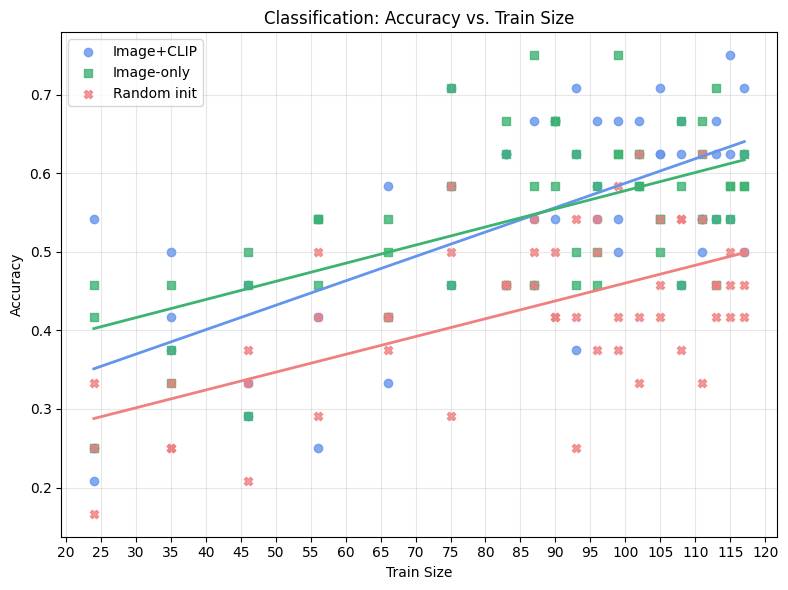

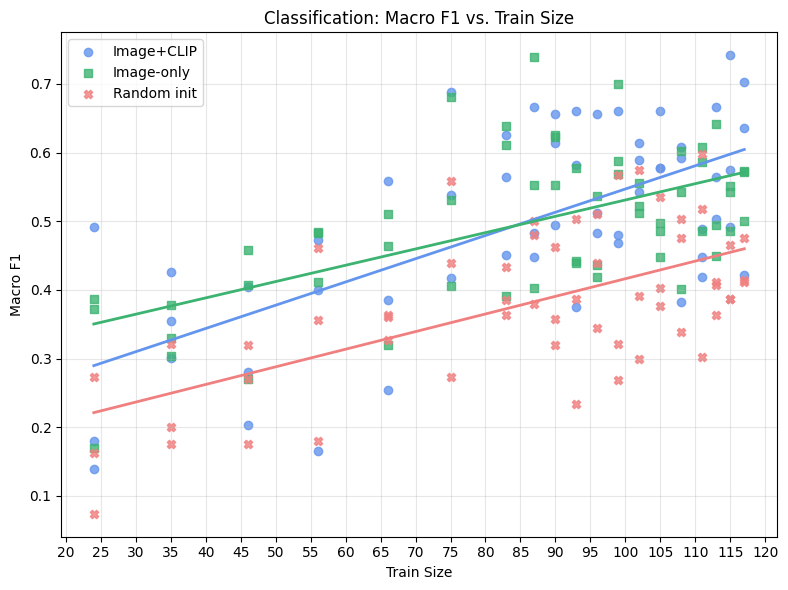

In [2]:
# load and plot all three series
df3 = load_all_series(
    root_clip="/midtier/paetzollab/scratch/ads4015/temp_selma_classification_preds_autumn_sweep_27",
    root_image="/midtier/paetzollab/scratch/ads4015/temp_selma_classification_preds_expert_sweep_31",
    root_random="/midtier/paetzollab/scratch/ads4015/temp_selma_classification_preds_random"
)

plot_classification_three_series(df3, metric="acc")
plot_classification_three_series(df3, metric="macro_f1")



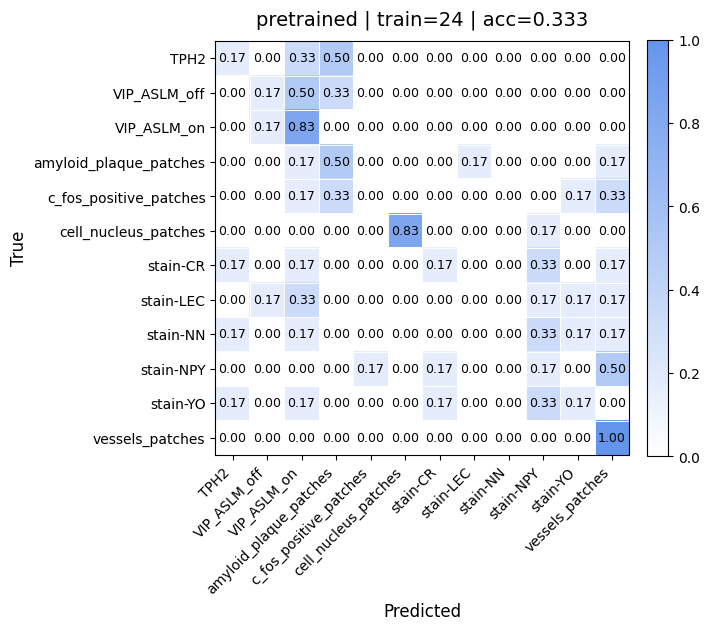

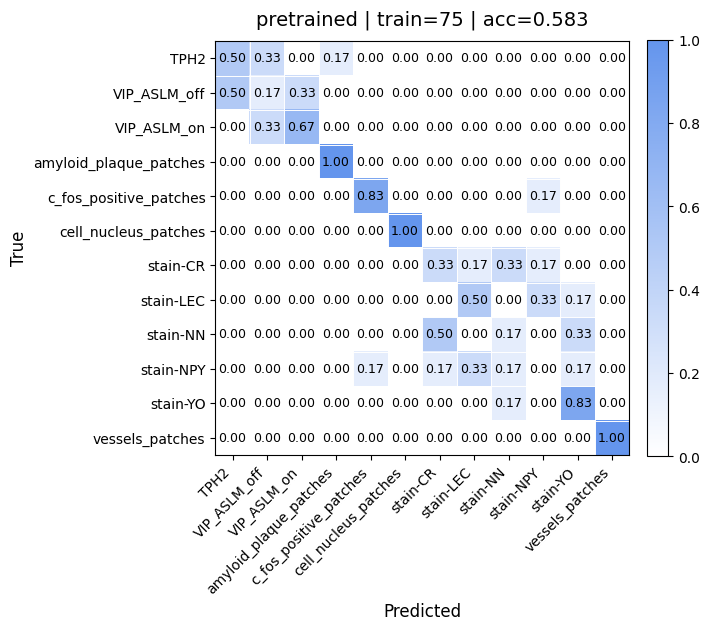

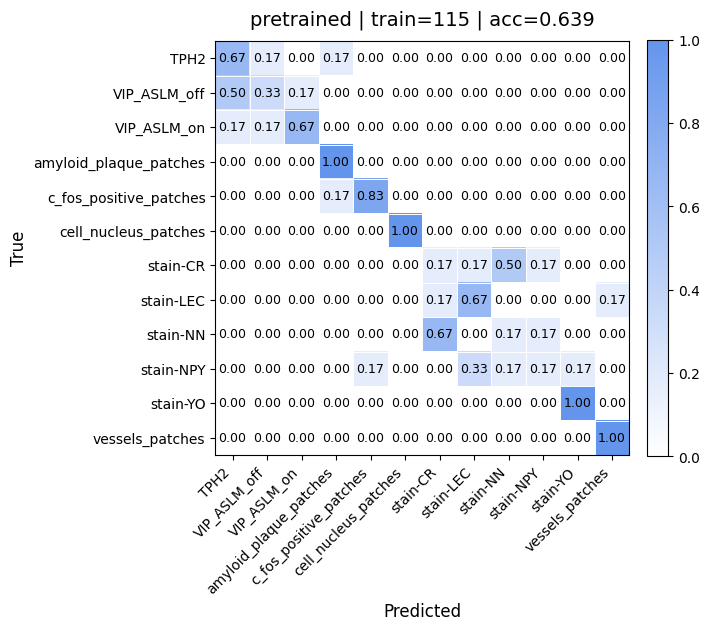

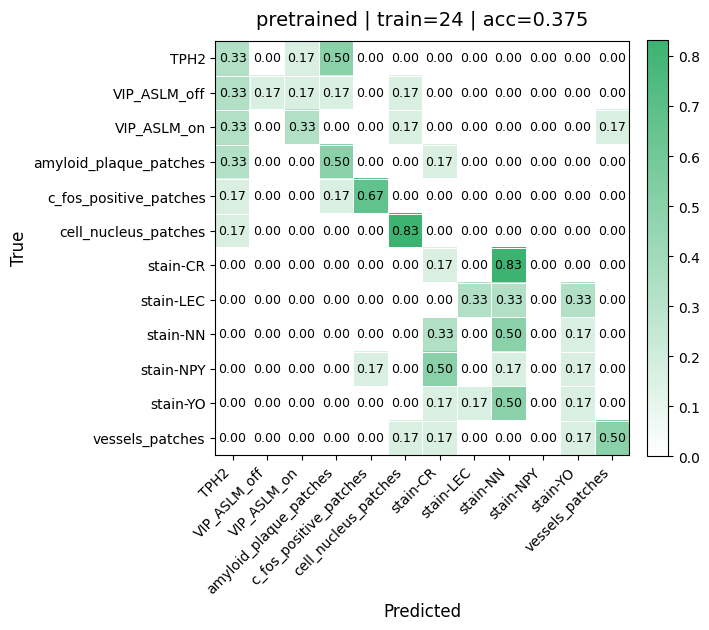

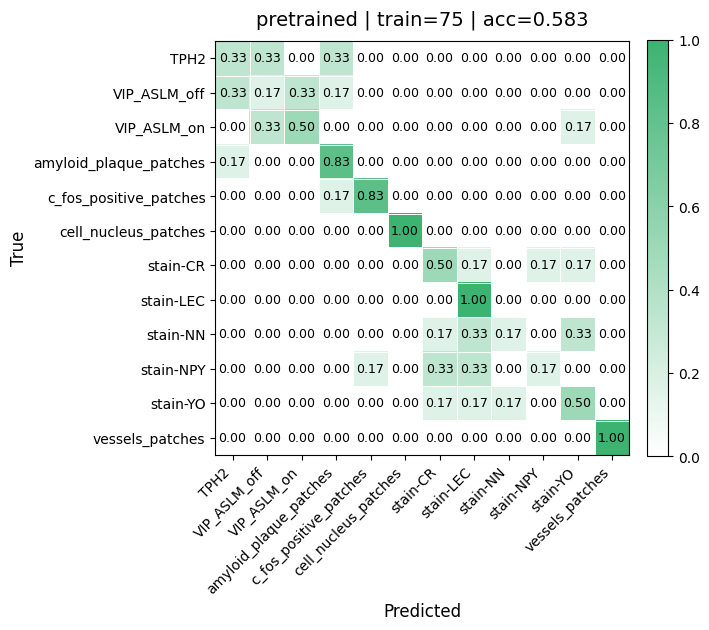

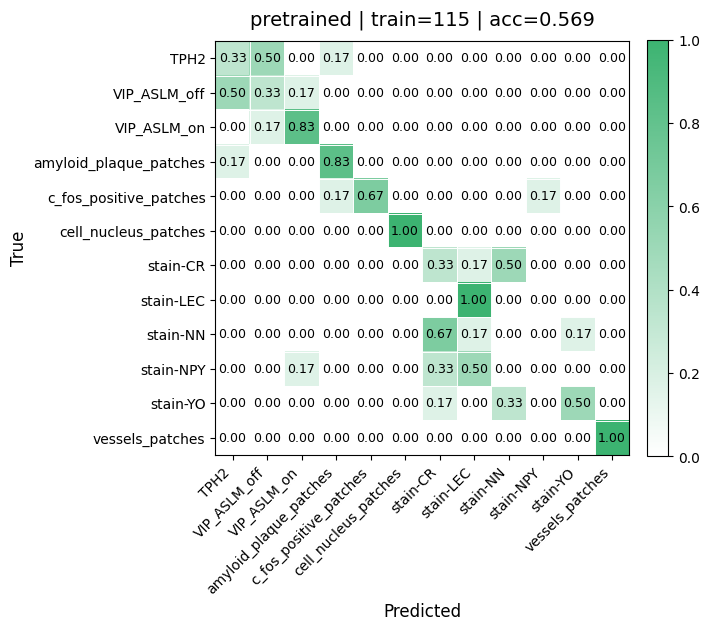

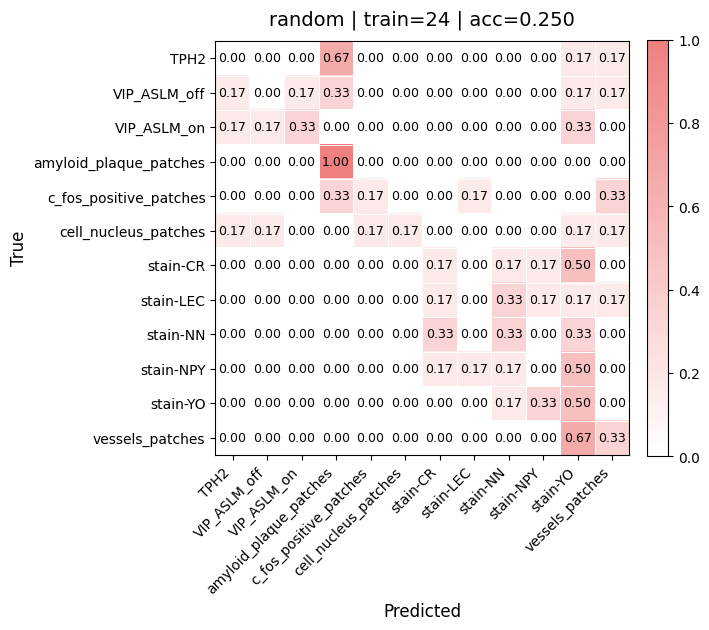

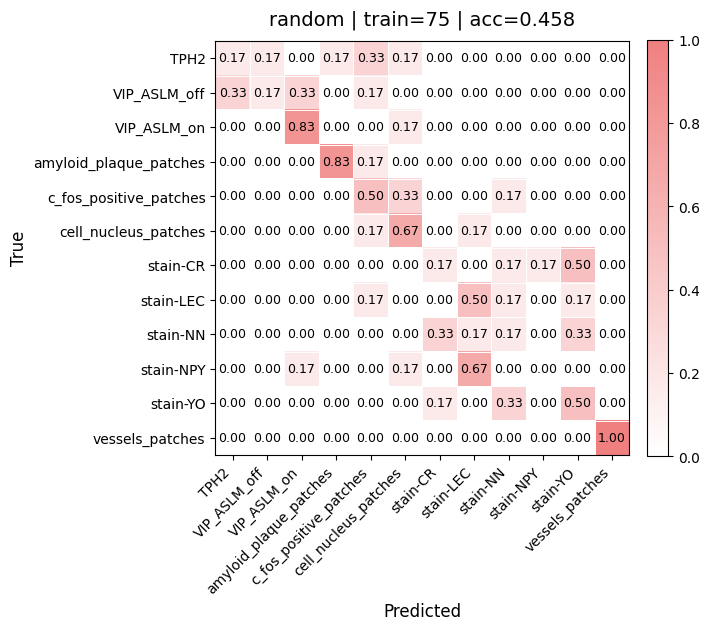

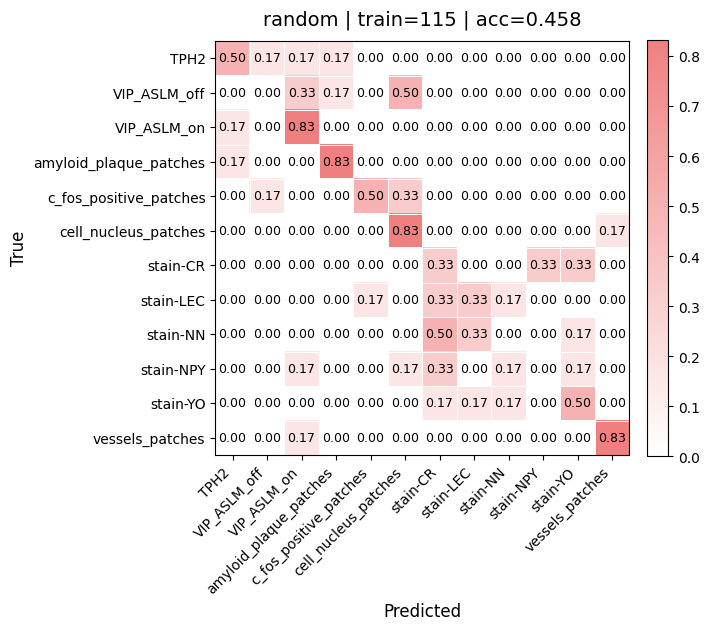

In [3]:
# Image+CLIP confusion matrices
df_cm = collect_confusion_matrices("/midtier/paetzollab/scratch/ads4015/temp_selma_classification_preds_autumn_sweep_27/cls_metrics/classification")
plot_heatmaps_for_train_sizes(df_cm, train_sizes=[24, 75, 115], normalize=True)

# Image-only confusion matrices
df_cm_image = collect_confusion_matrices("/midtier/paetzollab/scratch/ads4015/temp_selma_classification_preds_expert_sweep_31/cls_metrics/classification")
plot_heatmaps_for_train_sizes(df_cm_image, train_sizes=[24, 75, 115], normalize=True)

# Random init confusion matrices
df_cm_random = collect_confusion_matrices("/midtier/paetzollab/scratch/ads4015/temp_selma_classification_preds_random/cls_metrics/classification")
plot_heatmaps_for_train_sizes(df_cm_random, train_sizes=[24, 75, 115], normalize=True)
